#### Prédiction du prix des voitures d'occasion : Introduction et méthodologie

Ce notebook présente une démarche complète de data science visant à prédire le prix de voitures d'occasion à partir de leurs caractéristiques. Nous utilisons un jeu de données annoté, où chaque voiture est décrite par des variables (année, kilométrage, marque, modèle, etc.) et associée à un prix de vente connu. Il s'agit donc d'un problème de **régression supervisée** sur des valeurs continues.

#### Objectif

L'objectif est de construire des modèles capables d'estimer le prix d'une voiture à partir de ses attributs, afin d'aider vendeurs et acheteurs à mieux évaluer la valeur d'un véhicule.

#### Démarche suivie

- **Exploration et préparation des données** : Nettoyage, gestion des valeurs manquantes, transformation des variables (logarithme pour prix et kilométrage), regroupement des catégories rares, et encodage des variables catégorielles.
- **Séparation des données** : Division en ensembles d'entraînement et de test pour évaluer la capacité de généralisation des modèles.
- **Standardisation** : Mise à l'échelle des variables numériques pour garantir de bonnes performances des algorithmes.
- **Modélisation** : Application de plusieurs algorithmes de régression :
    - **Régression Linéaire** : Modèle de base pour établir une première référence.
    - **Régression Lasso** : Variante de la régression linéaire intégrant une régularisation L1 pour limiter le surapprentissage et sélectionner les variables pertinentes.
- **Évaluation** : Analyse des performances sur les ensembles d'entraînement et de test à l'aide de métriques adaptées (R², MAE, MSE).
- **Prédiction** : Utilisation des modèles pour estimer le prix de nouveaux véhicules.

> **Remarque :** Ce notebook se concentre sur la régression linéaire et la régression Lasso. L'utilisation d'un modèle plus avancé comme **XGBoost** sera abordée dans un notebook séparé.

#### Pourquoi un problème de régression supervisée ?

- **Supervisé** : Les données sont annotées, c'est-à-dire que pour chaque exemple (voiture), la valeur cible (prix) est connue.
- **Régression** : La variable à prédire (prix) est continue, contrairement à un problème de classification où la cible serait discrète (catégorie).
- **Valeur ajoutée** : Ce type de modèle permet d'automatiser l'estimation de prix, d'objectiver les transactions et d'identifier les facteurs influençant la valeur d'un véhicule.

Ce notebook illustre ainsi toutes les étapes d'un projet de machine learning supervisé appliqué à la prédiction de valeurs continues.

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

**Chargement et exploration des données**

Charger les données des voitures depuis un fichier CSV et effectuer une analyse préliminaire.

In [135]:
import os

# Lecture du fichier nettoyé
# Définir le chemin relatif à la racine du projet
project_root = os.path.dirname(os.path.abspath(''))
data_path = os.path.join(project_root, 'data', 'avito_cars_clean.csv')
car_dataset = pd.read_csv(data_path)

# Inspection des 5 premières lignes du dataframe
print("5 premières lignes du dataframe:")
print(car_dataset.head())

# Vérification du nombre de lignes et de colonnes
print("\nNombre de lignes et de colonnes dans le jeu de données:")
print(car_dataset.shape)

# Obtention d'informations sur le jeu de données
print("\nInformations sur le jeu de données:")
print(car_dataset.info())

# Vérification du nombre de valeurs manquantes
print("\nNombre de valeurs manquantes dans le jeu de données:")
print(car_dataset.isnull().sum())

5 premières lignes du dataframe:
   annee        boite carburant  kilometrage      marque    modele  \
0   2023  Automatique   Essence      22499.5  Alfa Romeo    Tonale   
1   2018     Manuelle    Diesel     104999.5       Dacia    Duster   
2   2023  Automatique    Diesel      67499.5     Hyundai    Accent   
3   2023  Automatique    Diesel      22499.5     Peugeot      5008   
4   2021  Automatique    Diesel      77499.5         Kia  Sportage   

   nombre_portres premiere_main  puissance_fiscale       etat    prix  
0               5           Oui                  8  Excellent  306000  
1               5           Oui                  6  Excellent  155000  
2               5           Oui                  6  Excellent  179000  
3               5           Oui                  8  Excellent  349000  
4               5           Oui                 12   Très bon  685000  

Nombre de lignes et de colonnes dans le jeu de données:
(68415, 11)

Informations sur le jeu de données:
<class '

**Analyse des variables catégorielles**

Examiner la répartition des valeurs dans les variables catégorielles du jeu de données.

In [136]:
# Vérification de la distribution des données catégorielles
print("\nDistribution des données catégorielles:")
print(car_dataset['boite'].value_counts())
print(car_dataset['carburant'].value_counts())
print(car_dataset['marque'].value_counts())
print(car_dataset['modele'].value_counts())
print(car_dataset['premiere_main'].value_counts())
print(car_dataset['etat'].value_counts())


Distribution des données catégorielles:
boite
Manuelle       47714
Automatique    20701
Name: count, dtype: int64
carburant
Diesel        54300
Essence       13181
Hybride         718
Electrique      180
LPG              36
Name: count, dtype: int64
marque
Renault          8572
Volkswagen       7982
Peugeot          6261
Dacia            5938
Mercedes-Benz    4830
                 ... 
Lincoln             1
Force               1
Rolls-Royce         1
Lada                1
UFO                 1
Name: count, Length: 75, dtype: int64
modele
Clio        2707
Logan       2140
Sandero     1397
Tiguan      1394
Kangoo      1325
            ... 
Kubistar       1
UX             1
Dzire          1
Allante        1
Orion          1
Name: count, Length: 803, dtype: int64
premiere_main
Non    47621
Oui    20794
Name: count, dtype: int64
etat
Excellent      31359
Très bon       24208
Bon             9256
Neuf            2115
Correct         1380
Endommagé         53
Pour Pièces       44
Name: count

**Regroupement des catégories rares**

Regrouper les marques et modèles peu fréquents en une catégorie 'Other' pour simplifier le modèle.

In [137]:
# Ingénierie des caractéristiques : Regroupement des catégories rares de marque et modèle
marque_counts = car_dataset['marque'].value_counts()
modele_counts = car_dataset['modele'].value_counts()
car_dataset['marque'] = car_dataset['marque'].apply(lambda x: x if marque_counts[x] >= 100 else 'Other')
car_dataset['modele'] = car_dataset['modele'].apply(lambda x: x if modele_counts[x] >= 100 else 'Other')

**Visualisation des données après regroupement**

Afficher les premières lignes du DataFrame après le regroupement des catégories.

In [138]:
car_dataset.head()

,annee,boite,carburant,kilometrage,marque,modele,nombre_portres,premiere_main,puissance_fiscale,etat,prix
0,2023,Automatique,Essence,22499.5,Alfa Romeo,Other,5,Oui,8,Excellent,306000
1,2018,Manuelle,Diesel,104999.5,Dacia,Duster,5,Oui,6,Excellent,155000
2,2023,Automatique,Diesel,67499.5,Hyundai,Accent,5,Oui,6,Excellent,179000
3,2023,Automatique,Diesel,22499.5,Peugeot,Other,5,Oui,8,Excellent,349000
4,2021,Automatique,Diesel,77499.5,Kia,Sportage,5,Oui,12,Très bon,685000


**Transformation logarithmique**

Appliquer une transformation logarithmique au prix et au kilométrage pour réduire l'impact des valeurs extrêmes.

In [139]:
# Transformation logarithmique pour prix et kilométrage pour gérer les valeurs aberrantes
car_dataset['prix'] = np.log1p(car_dataset['prix'])
car_dataset['kilometrage'] = np.log1p(car_dataset['kilometrage'])

**Encodage des variables catégorielles**

Convertir les variables catégorielles en format numérique avec l'encodage one-hot.

In [140]:
# Encodage one-hot des colonnes catégorielles
categorical_cols = ['boite', 'carburant', 'marque', 'modele', 'premiere_main', 'etat']
car_dataset = pd.get_dummies(car_dataset, columns=categorical_cols, drop_first=True)

**Préparation des features et de la cible**

Séparer les données en variables explicatives (X) et variable à prédire (Y).

In [141]:
# Division des données en caractéristiques (X) et variable cible (Y)
X = car_dataset.drop(['prix'], axis=1)
Y = car_dataset['prix']

**Division en ensembles d'entraînement et de test**

Répartir les données en ensembles d'entraînement et de test pour évaluer les modèles.

In [142]:
# Séparation entre données d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

**Standardisation des variables numériques**

Normaliser les variables numériques pour améliorer la performance des modèles.

In [143]:
# Mise à l'échelle des caractéristiques numériques
numerical_cols = ['annee', 'kilometrage', 'nombre_portres', 'puissance_fiscale']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

**Création et entraînement du modèle de Régression Linéaire**

Créer et entraîner un modèle de régression linéaire avec les données d'entraînement.

In [144]:
# Entraînement et évaluation de la Régression Linéaire standard
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

**Évaluation du modèle de Régression Linéaire sur l'ensemble d'entraînement**

Mesurer les performances du modèle sur les données d'entraînement avec différentes métriques.

In [145]:
# Prédiction sur les données d'entraînement (Régression Linéaire)
train_data_prediction_lr = lr_model.predict(X_train)
train_r2_lr = metrics.r2_score(Y_train, train_data_prediction_lr)
train_mae_lr = metrics.mean_absolute_error(Y_train, train_data_prediction_lr)
train_mse_lr = metrics.mean_squared_error(Y_train, train_data_prediction_lr)
print("\nRégression Linéaire R² sur les données d'entraînement:", train_r2_lr)
print("Régression Linéaire MAE sur les données d'entraînement:", train_mae_lr)
print("Régression Linéaire MSE sur les données d'entraînement:", train_mse_lr)


Régression Linéaire R² sur les données d'entraînement: 0.8102797426836399
Régression Linéaire MAE sur les données d'entraînement: 0.19020948372162927
Régression Linéaire MSE sur les données d'entraînement: 0.1079224631561993


**Évaluation du modèle de Régression Linéaire sur l'ensemble de test**

Mesurer les performances du modèle sur les données de test pour vérifier sa capacité de généralisation.

In [146]:
# Prédiction sur les données de test (Régression Linéaire)
test_data_prediction_lr = lr_model.predict(X_test)
test_r2_lr = metrics.r2_score(Y_test, test_data_prediction_lr)
test_mae_lr = metrics.mean_absolute_error(Y_test, test_data_prediction_lr)
test_mse_lr = metrics.mean_squared_error(Y_test, test_data_prediction_lr)
print("Régression Linéaire R² sur les données de test:", test_r2_lr)
print("Régression Linéaire MAE sur les données de test:", test_mae_lr)
print("Régression Linéaire MSE sur les données de test:", test_mse_lr)

Régression Linéaire R² sur les données de test: 0.8057580524367022
Régression Linéaire MAE sur les données de test: 0.1924973660593798
Régression Linéaire MSE sur les données de test: 0.11114178763106641


**Création et entraînement du modèle Lasso**

Créer et entraîner un modèle de régression Lasso qui ajoute une régularisation L1.

In [147]:
# Entraînement et évaluation de la Régression Linéaire avec Lasso
lasso_model = Lasso(alpha=0.01, random_state=10)
lasso_model.fit(X_train, Y_train)

Lasso(alpha=0.01, random_state=10)

**Évaluation du modèle Lasso sur l'ensemble d'entraînement**

Mesurer les performances du modèle Lasso sur les données d'entraînement.

In [148]:
# Prédiction sur les données d'entraînement (Lasso)
train_data_prediction_lasso = lasso_model.predict(X_train)
train_r2_lasso = metrics.r2_score(Y_train, train_data_prediction_lasso)
train_mae_lasso = metrics.mean_absolute_error(Y_train, train_data_prediction_lasso)
train_mse_lasso = metrics.mean_squared_error(Y_train, train_data_prediction_lasso)
print("\nRégression Lasso R² sur les données d'entraînement:", train_r2_lasso)
print("Régression Lasso MAE sur les données d'entraînement:", train_mae_lasso)
print("Régression Lasso MSE sur les données d'entraînement:", train_mse_lasso)


Régression Lasso R² sur les données d'entraînement: 0.7442956046985733
Régression Lasso MAE sur les données d'entraînement: 0.2539057893661868
Régression Lasso MSE sur les données d'entraînement: 0.1454575730138268


**Évaluation du modèle Lasso sur l'ensemble de test**

Mesurer les performances du modèle Lasso sur les données de test.

In [149]:
# Prédiction sur les données de test (Lasso)
test_data_prediction_lasso = lasso_model.predict(X_test)
test_r2_lasso = metrics.r2_score(Y_test, test_data_prediction_lasso)
test_mae_lasso = metrics.mean_absolute_error(Y_test, test_data_prediction_lasso)
test_mse_lasso = metrics.mean_squared_error(Y_test, test_data_prediction_lasso)
print("Régression Lasso R² sur les données de test:", test_r2_lasso)
print("Régression Lasso MAE sur les données de test:", test_mae_lasso)
print("Régression Lasso MSE sur les données de test:", test_mse_lasso)

Régression Lasso R² sur les données de test: 0.7396760085523575
Régression Lasso MAE sur les données de test: 0.2562146515863321
Régression Lasso MSE sur les données de test: 0.14895275781415365


**Prédiction sur un nouvel exemple**

Utiliser les modèles pour prédire le prix d'une nouvelle voiture avec des caractéristiques spécifiques.

In [150]:
# Prédiction du prix pour une nouvelle voiture: Volkswagen Tiguan, 2009, 200000 km, 8 CV, Automatique, Diesel, Excellent
new_car = pd.DataFrame({
    'marque': ['Volkswagen'],
    'modele': ['Tiguan'],
    'annee': [2009],
    'kilometrage': [20000],
    'puissance_fiscale': [8],
    'boite': ['Automatique'],
    'carburant': ['Diesel'],
    'etat': ['Excellent'],
    'premiere_main': ['Non'],
    'nombre_portres': [5]  
})

# Appliquer la même ingénierie de caractéristiques
new_car['marque'] = new_car['marque'].apply(lambda x: x if marque_counts.get(x, 0) >= 100 else 'Other')
new_car['modele'] = new_car['modele'].apply(lambda x: x if modele_counts.get(x, 0) >= 100 else 'Other')
new_car['kilometrage'] = np.log1p(new_car['kilometrage'])

# Encodage one-hot des colonnes catégorielles
categorical_cols = ['boite', 'carburant', 'marque', 'modele', 'premiere_main', 'etat']
new_car_encoded = pd.get_dummies(new_car, columns=categorical_cols, drop_first=True)

# Aligner les caractéristiques de la nouvelle voiture avec les données d'entraînement (ajouter les colonnes manquantes avec zéros)
for col in X.columns:
    if col not in new_car_encoded.columns:
        new_car_encoded[col] = 0
new_car_encoded = new_car_encoded[X.columns]

# Mise à l'échelle des caractéristiques numériques
numerical_cols = ['annee', 'kilometrage', 'nombre_portres', 'puissance_fiscale']
new_car_encoded[numerical_cols] = scaler.transform(new_car_encoded[numerical_cols])

# Faire des prédictions
lr_pred = lr_model.predict(new_car_encoded)
lasso_pred = lasso_model.predict(new_car_encoded)

# Transformer les prédictions à l'échelle de prix originale
print("\nPrix prédits pour Volkswagen Tiguan (2009, 200000 km, 8 CV, Automatique, Diesel, Excellent):")
print(f"Régression Linéaire: {np.expm1(lr_pred[0]):.2f} MAD")
print(f"Lasso optimisé: {np.expm1(lasso_pred[0]):.2f} MAD")


Prix prédits pour Volkswagen Tiguan (2009, 200000 km, 8 CV, Automatique, Diesel, Excellent):
Régression Linéaire: 105589.72 MAD
Lasso optimisé: 121270.81 MAD


**Visualisation des prédictions**

Créer un graphique pour comparer les valeurs prédites avec les valeurs réelles.

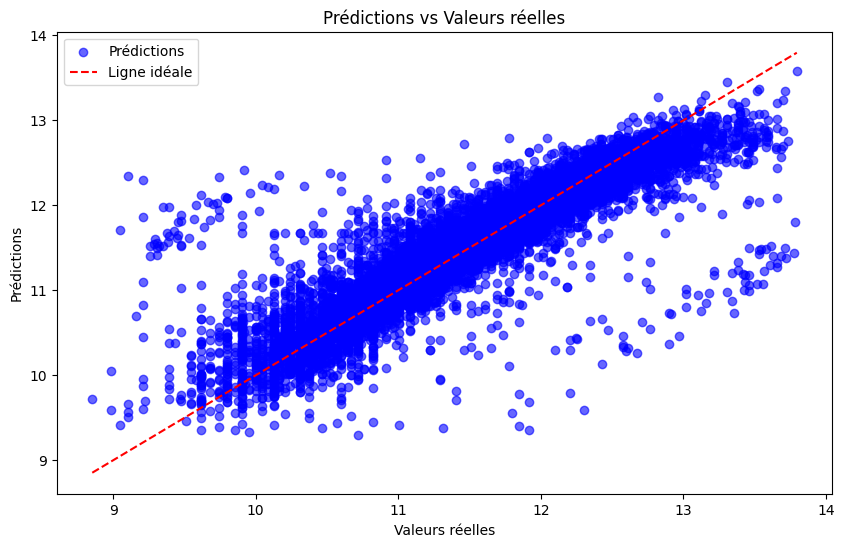

In [151]:
# Prédiction vs Valeurs réelles LR
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, test_data_prediction_lr, color='blue', label='Prédictions', alpha=0.6)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', label='Ligne idéale', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.legend()
plt.show()


**Sauvegarde du modèle de régression linéaire**

Enregistrer le modèle de régression linéaire et ses composants pour une utilisation future.

In [152]:
# Utiliser le chemin relatif basé sur project_root
import joblib

pkl_dir = os.path.join(project_root, 'pkl-files')
os.makedirs(pkl_dir, exist_ok=True)

# Sauvegarder le scaler
joblib.dump(scaler, os.path.join(pkl_dir, 'linear_regression_scaler.pkl'))

# Sauvegarder le modèle
joblib.dump(lr_model, os.path.join(pkl_dir, 'linear_regression_model.pkl'))

# Sauvegarder les colonnes
joblib.dump(X.columns, os.path.join(pkl_dir, 'linear_regression_columns.pkl'))

print("Le scaler et le modèle de régression linéaire ont été sauvegardés sous forme de fichiers .pkl dans le dossier du projet.")

Le scaler et le modèle de régression linéaire ont été sauvegardés sous forme de fichiers .pkl dans le dossier du projet.


**Sauvegarde du modèle Lasso**

Enregistrer le modèle Lasso et ses composants pour une utilisation future.

In [153]:
import joblib

# Utiliser le chemin relatif basé sur project_root
pkl_dir = os.path.join(project_root, 'pkl-files')
os.makedirs(pkl_dir, exist_ok=True)

# Sauvegarder le scaler
joblib.dump(scaler, os.path.join(pkl_dir, 'lasso_scaler.pkl'))

# Sauvegarder le modèle
joblib.dump(lasso_model, os.path.join(pkl_dir, 'lasso_model.pkl'))

# Sauvegarder les colonnes
joblib.dump(X.columns, os.path.join(pkl_dir, 'lasso_columns.pkl'))

print("Le scaler et le modèle de Lasso ont été sauvegardés sous forme de fichiers .pkl.")

Le scaler et le modèle de Lasso ont été sauvegardés sous forme de fichiers .pkl.


**Travail Réalisé par EL ANNASI Nada et EL-GHEFYRY Salma**